In [1]:
import scipy.io
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import StepLR

# Load the Matlab file
mat_file = scipy.io.loadmat('Sensor_new2.mat')

# Access the variables in the Matlab file
input = mat_file['S_learn']
target = mat_file['F_learn']

'''
scaler = StandardScaler()
nor_input = scaler.fit_transform(input)
nor_target = scaler.fit_transform(target*1000)
input = np.asarray(np.transpose(nor_input))
target = np.asarray(np.transpose(nor_target))
'''

input = np.asarray(np.transpose(input))
target = np.asarray(np.transpose(target))*1000

print(input.shape)
print(target.shape)

class MyDataset(torch.utils.data.Dataset):
    '''
    Prepare the Boston dataset for regression
    '''

    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# X, y = load_boston(return_X_y=True)
dataset = MyDataset(input, target)
print(dataset.__getitem__(0))
print("dataset loaded")

(540000, 3)
(540000, 3)
(tensor([1.2429, 1.7911, 1.2775], dtype=torch.float64), tensor([ 1.4935,  3.4693, -0.6015], dtype=torch.float64))
dataset loaded


In [2]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
             nn.Linear(3, 50),
             nn.LeakyReLU(),
             #nn.Dropout(p=0.1),
             nn.Linear(50, 200),
             nn.LeakyReLU(),
             #nn.Dropout(p=0.1),
             nn.Linear(200, 500),
             nn.LeakyReLU(),
             #nn.Dropout(p=0.1),
             nn.Linear(500, 300),
             nn.LeakyReLU(),
             nn.Linear(300, 200),
             nn.LeakyReLU(),
             nn.Linear(200, 100),
             nn.LeakyReLU(),
             #nn.Dropout(p=0.1),
             nn.Linear(100, 80),
             nn.LeakyReLU(),
             # nn.Dropout(p=0.1),
             nn.Linear(80, 30),
             nn.LeakyReLU(),
             #nn.Dropout(p=0.1),
             nn.Linear(30, 3)
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)


if __name__ == '__main__':

    # Set fixed random number seed
    torch.manual_seed(42)

    # Load Boston dataset


    # Prepare Boston dataset

    trainloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)

    # Initialize the MLP
    mlp = MLP()
    mlp.train()
    # Define the loss function and optimizer
    loss_function = nn.MSELoss()
    # loss_function = nn.L1Loss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-2)
    scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
    # Run the training loop
    for epoch in range(0, 120):  # 5 epochs at maximum

        # Print epoch
        print(f'Starting epoch {epoch + 1}')

        print('Learning rate :%.5f' %(optimizer.param_groups[0]['lr']))

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):

            # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 3))

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = mlp(inputs)

            # Compute loss
            loss = loss_function(outputs, targets)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            current_loss += loss.item()
            if i % 1000 == 0:
                print('Loss after mini-batch %5d: %.6f' %
                      (i + 1, current_loss / 1000))
                current_loss = 0.0
        scheduler.step()
    # Process is complete.
    print('Training process has finished.')

Starting epoch 1
Learning rate :0.01000
Loss after mini-batch     1: 12.968814
Starting epoch 2
Learning rate :0.01000
Loss after mini-batch     1: 0.012961
Starting epoch 3
Learning rate :0.01000
Loss after mini-batch     1: 0.006417
Starting epoch 4
Learning rate :0.01000
Loss after mini-batch     1: 0.004386
Starting epoch 5
Learning rate :0.01000
Loss after mini-batch     1: 0.005947
Starting epoch 6
Learning rate :0.01000
Loss after mini-batch     1: 0.014726
Starting epoch 7
Learning rate :0.01000
Loss after mini-batch     1: 0.007072
Starting epoch 8
Learning rate :0.01000
Loss after mini-batch     1: 0.004638
Starting epoch 9
Learning rate :0.01000
Loss after mini-batch     1: 0.006253
Starting epoch 10
Learning rate :0.01000
Loss after mini-batch     1: 0.013119
Starting epoch 11
Learning rate :0.01000
Loss after mini-batch     1: 0.008602
Starting epoch 12
Learning rate :0.01000
Loss after mini-batch     1: 4.431191
Starting epoch 13
Learning rate :0.01000
Loss after mini-bat

In [6]:
sample1, target1 = dataset.__getitem__(500)
sample1 = torch.unsqueeze(sample1,0)
sample1 = sample1.float()
target1 = target1.float()
mlp.eval()
with torch.no_grad():
    prediction = mlp(sample1)
print('sample:', sample1)
print('target:', target1)
print('prediction:', prediction)

sample: tensor([[1.2358, 1.7858, 1.2851]])
target: tensor([ 1.0678,  2.8681, -0.5726])
prediction: tensor([[ 1.1879,  2.9333, -0.3818]])


In [5]:
print(torch.cuda.is_available())

True


In [8]:
A = np.random.randn(4,2)*0.01
B = np.random.randn(2, 3)
result = np.dot(A, B)
print(result)

[[ 0.01007797 -0.03425962  0.00593765]
 [-0.00693126 -0.0038656  -0.00178333]
 [-0.01378484  0.02839409 -0.00657284]
 [-0.03183492  0.03022018 -0.01221434]]


In [5]:
# Train the model and save it
torch.save(mlp.state_dict(), 'network_checkpoint.pth')

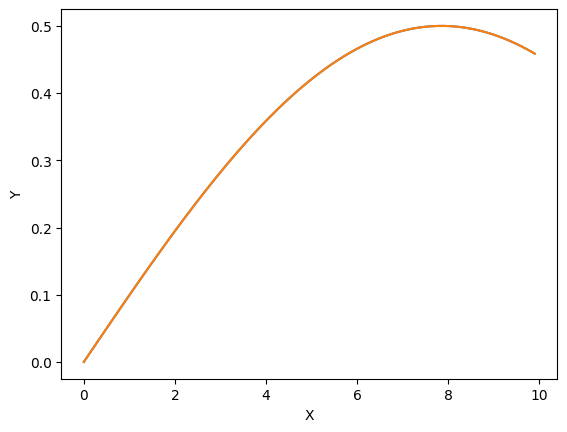

In [8]:

import numpy as np

import matplotlib.pyplot as plt



# Get x values of the sine wave

time        = np.arange(0, 10, 0.1);



# Amplitude of the sine wave is sine of a variable like time

amplitude   = 0.5*np.sin(0.2*time)
plt.plot(time, amplitude)
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('test.pdf')
plt.plot(time, amplitude)

In [3]:
plot.savefig('test.pdf')

<Figure size 640x480 with 0 Axes>